In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import json
import os
import re
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
### Read representative cells
# adata = sc.read_h5ad('/home/jovyan/work/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')
# adata = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_L2_repcells_loginv_Harmony_noZ.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_L1_repcells_loginv_Harmony_noZ.h5ad')

print('Original adata:', adata.shape)
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)

Original adata: (59897, 27504)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [3]:
Hao_genes = adata.var_names.tolist()
len(Hao_genes)

27504

## Fisher exact test

In [4]:
import scipy.stats as stats

def perform_fisher_test(PreLect_genes, ACT_genes, Hao_genes):
    """
    Performs Fisher's exact test on the provided gene sets.

    Parameters:
    - PreLect_genes: Set of genes in PreLect_genes.
    - ACT_genes: Set of genes in ACT_genes.
    - Hao_genes: Set of all genes in Hao_genes (background population).

    Returns:
    - oddsratio: The odds ratio calculated from the contingency table.
    - p_value: The p-value from Fisher's exact test.
    """
    # Ensure the inputs are sets
    PreLect_genes = set(PreLect_genes)
    ACT_genes = set(ACT_genes)
    Hao_genes = set(Hao_genes)

    # Calculate the counts for the contingency table
    a = len(PreLect_genes & ACT_genes)                   # Genes in both PreLect_genes and ACT_genes
    b = len(PreLect_genes - ACT_genes)                   # Genes in PreLect_genes but not in ACT_genes
    c = len(ACT_genes - PreLect_genes)                   # Genes in ACT_genes but not in PreLect_genes
    d = len(Hao_genes - (PreLect_genes | ACT_genes))     # Genes in neither gene set

    # Construct the contingency table
    contingency_table = [[a, b],
                         [c, d]]

    # Perform Fisher's exact test
    oddsratio, p_value = stats.fisher_exact(contingency_table)

    # Output the results
    print("Contingency Table:")
    print(f"                   In ACT_genes    Not in ACT_genes")
    print(f"In PreLect_genes       {a}               {b}")
    print(f"Not in PreLect_genes   {c}            {d}")
    print(f"\nOdds Ratio: {oddsratio}")
    print(f"P-value: {p_value}")

    return oddsratio, p_value

# OR > 1: 
#   Indicates a positive association between being in PreLect_genes and being in ACT_genes
#   Genes in PreLect_genes are more likely to be in ACT_genes compared to genes not in PreLect_genes
#   The higher the OR, the stronger the positive association between PreLect_genes and ACT_genes


## Read ACT markers

In [4]:
# marker_df = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/ACT_annotation/Human_blood_marker_processed.csv')
# marker_df = pd.read_csv(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\ACT_annotation\Human_blood_marker_processed.csv")
marker_df = pd.read_csv(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/ACT_annotation/Human_blood_marker_processed.csv')

print(marker_df.shape)
marker_df.head()

(147, 6)


,Species,Tissue,super_type,CellType,Marker,Resource
0,Human,Blood,B,Activated B cell,"CD5, MIR155HG, TAGLN2","35025971, 28910360, 2474446"
1,Human,Blood,T_CD4,"Activated CD4-positive, alpha-beta T cell","CD4, CCR6, CD14, CD19, CD38, CD3D, CD3G, CD69,...","35381424, 32783921, 35831277, 34529726, 103413..."
2,Human,Blood,T_CD4,"Activated CD4-positive, CD25-positive, CCR4-po...","CD3D, CD3E, CD3G, CD4, FOXP3",30977974
3,Human,Blood,NaN,Adult endothelial progenitor cell,"KDR, PROM1, CD34, PTPRC, PECAM1, CD14","27561827, 29391882, 24641802, 29147957, 267700..."
4,Human,Blood,T,Alpha-beta T cell,"CD3D, CD3E, CD3G, IL7R","34284174, 28777444"


In [6]:
def get_celltype_marker(name, marker_df):
    string = marker_df[marker_df['CellType'] == name]['Marker'].tolist()[0]  # Erythrocyte Platelet?
    marker_set = set(string.split(', '))
    return marker_set

In [7]:
clus_name_pairs = [
    ('B_memory', 'Memory B cell'),
    ('B_naive', 'Naive B cell'),
    ('CD14_Mono', 'Classical monocyte'),
    ('CD16_Mono', 'Non-classical monocyte'),
    ('CD4_Proliferating', 'Proliferating CD4-positive, alpha-beta T cell'),
    ('CD4_TCM', 'Central memory CD4-positive, alpha-beta T cell'),
    ('CD4_TEM', 'Effector memory CD4-positive, alpha-beta T cell'),
    ('CD8_Naive', 'Naive thymus-derived CD8-positive, alpha-beta T cell'),
    ('CD8_TEM', 'Effector memory CD8-positive, alpha-beta T cell'),
    ('cDC1', 'Type 1 conventional dendritic cell'),
    ('cDC2', 'Type 2 conventional dendritic cell'),
    ('gdT', 'Gamma-delta T cell'),
    ('HSPC', 'Hematopoietic stem cell'),
    ('MAIT', 'Mucosal invariant T cell'),
    ('pDC', 'Plasmacytoid dendritic cell'),
    ('Treg', 'Regulatory T cell'),
    ('CD4_CTL', 'CD4-positive, alpha-beta cytotoxic T cell'),
    ('CD4_Naive', 'Naive thymus-derived CD4-positive, alpha-beta T cell'),
    ('CD8_TCM', 'Central memory CD8-positive, alpha-beta T cell'),
    ('Plasmablast', 'Plasmablast'), 
    # More than 20 L2 celltypes
    ('Eryth', 'Erythrocyte'), 
    ('NK', 'Natural killer cell'), 
    ('NK_CD56bright', 'CD16-negative, CD56-bright natural killer cell, human'), 
    ('Platelet', 'Platelet')
    ## ACT not defined
    # ASDC
    # B_intermediate
    # CD8_Proliferating
    # Doublet
    # ILC
    # NK_Proliferating
    # dnT
]
cluster_2_ACT_name = dict(clus_name_pairs)
cluster_2_ACT_name

{'B_memory': 'Memory B cell',
 'B_naive': 'Naive B cell',
 'CD14_Mono': 'Classical monocyte',
 'CD16_Mono': 'Non-classical monocyte',
 'CD4_Proliferating': 'Proliferating CD4-positive, alpha-beta T cell',
 'CD4_TCM': 'Central memory CD4-positive, alpha-beta T cell',
 'CD4_TEM': 'Effector memory CD4-positive, alpha-beta T cell',
 'CD8_Naive': 'Naive thymus-derived CD8-positive, alpha-beta T cell',
 'CD8_TEM': 'Effector memory CD8-positive, alpha-beta T cell',
 'cDC1': 'Type 1 conventional dendritic cell',
 'cDC2': 'Type 2 conventional dendritic cell',
 'gdT': 'Gamma-delta T cell',
 'HSPC': 'Hematopoietic stem cell',
 'MAIT': 'Mucosal invariant T cell',
 'pDC': 'Plasmacytoid dendritic cell',
 'Treg': 'Regulatory T cell',
 'CD4_CTL': 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4_Naive': 'Naive thymus-derived CD4-positive, alpha-beta T cell',
 'CD8_TCM': 'Central memory CD8-positive, alpha-beta T cell',
 'Plasmablast': 'Plasmablast',
 'Eryth': 'Erythrocyte',
 'NK': 'Natural killer cel

In [8]:
len(cluster_2_ACT_name)

24

In [9]:
for celltype in types:
    if celltype in cluster_2_ACT_name.keys():
        continue
    else:
        print(celltype)

ASDC
B_intermediate
CD8_Proliferating
Doublet
ILC
NK_Proliferating
dnT


## For all types

In [10]:
def various_lmbd_PreLect_vs_ACT_fisher(celltype, ACT_genes, Hao_genes):
    # Define the regular expression pattern using the celltype variable
    pattern = re.compile(r'^{}_([0-9\.eE+-]+)_features\.txt$'.format(celltype))
    # start with B_, followed by a number (which can include digits, decimal points, signs, and exponential notation), and end with _features.txt

    # Under the celltype, get the feature set of different lambdas
    filenames = os.listdir()
    matching_files = [filename for filename in filenames if pattern.match(filename)]

    fisher_result = pd.DataFrame(columns=['Lambda', 'Feature_no', 'Odds_ratio', 'P-value'])
    
    for file in matching_files:
        print('=====')
        lmbd = float(file.split('_')[-2])
        print(lmbd)
        try:
            feature_df = pd.read_csv(file, names=['Gene', 'Weight', 'Tendency'], sep='\t')
            PreLect_genes_at_lmbd = feature_df['Gene'].tolist()
        except:
            print('File not exist:', file)
            continue
        print('PreLect feature no:', len(PreLect_genes_at_lmbd))
        OR, p_v = perform_fisher_test(PreLect_genes_at_lmbd, ACT_genes, Hao_genes)
        fisher_result = pd.concat([fisher_result, pd.DataFrame({'Lambda': [lmbd], 
                                                                'Feature_no': [len(PreLect_genes_at_lmbd)], 
                                                                'Odds_ratio': [OR], 
                                                                'P-value': [p_v]})])
    
    return fisher_result

In [ ]:
# os.chdir(r'C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\at_various_number\features_at_various_no')
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/large_lambda_various/at_various_number/features_at_various_no')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/large_lambda_various/at_various_number/features_at_various_no')

# output_path = r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\L2_fisher_result"
for clus, name in cluster_2_ACT_name.items():
    ACT_genes_celltype = get_celltype_marker(name, marker_df)
    # ACT_genes: remove any that are not part of Hao_genes
    ACT_genes_celltype = set(ACT_genes_celltype).intersection(set(Hao_genes))
    print('==========')
    print(f'{clus}, ACT markers no:', len(ACT_genes_celltype))

    fisher_result = various_lmbd_PreLect_vs_ACT_fisher(clus, ACT_genes_celltype, Hao_genes)
    fisher_result = fisher_result.sort_values('Feature_no')
    print(fisher_result)
    # fisher_result.to_csv(os.path.join(output_path, f'{clus}_fisher_result.csv'))

B_memory, ACT markers no: 17
=====
0.0006812920690579617
PreLect feature no: 70
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       4               66
Not in PreLect_genes   13            27421

Odds Ratio: 127.83682983682984
P-value: 8.928365509277908e-08
=====
0.0010000000000000002
PreLect feature no: 56
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       4               52
Not in PreLect_genes   13            27435

Odds Ratio: 162.33727810650888
P-value: 3.5955326490408636e-08
=====
0.0014677992676220694
PreLect feature no: 41
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       4               37
Not in PreLect_genes   13            27450

Odds Ratio: 228.2744282744283
P-value: 9.970125261308704e-09
=====
0.003162277660168382
PreLect feature no: 26
Contingency Table:
                   In ACT_genes    Not in ACT_genes
In PreLect_genes       3               2

In [14]:
l2_colors = adata.uns['celltype.l2_colors']
l2_colors

array(['#ffff00', '#1ce6ff', '#ff34ff', '#ff4a46', '#008941', '#006fa6',
       '#a30059', '#ffdbe5', '#7a4900', '#0000a6', '#63ffac', '#b79762',
       '#004d43', '#8fb0ff', '#997d87', '#5a0007', '#809693', '#6a3a4c',
       '#1b4400', '#4fc601', '#3b5dff', '#4a3b53', '#ff2f80', '#61615a',
       '#ba0900', '#6b7900', '#00c2a0', '#ffaa92', '#ff90c9', '#b903aa',
       '#d16100'], dtype=object)

In [15]:
from matplotlib import cm
tab20 = cm.get_cmap('tab20').colors
color_count = 0

/var/folders/t1/zclr_f3s57j185f2tblqgwt00000gn/T/ipykernel_18845/2709456469.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = cm.get_cmap('tab20').colors


No file ASDC
No file B_intermediate
Result single lambda B_naive
Skipping CD4_CTL
Skipping CD4_Proliferating
No file CD8_Proliferating
No file Doublet
Result empty Eryth
No file ILC
No file NK_Proliferating
Result empty Platelet
Result single lambda cDC2
No file dnT


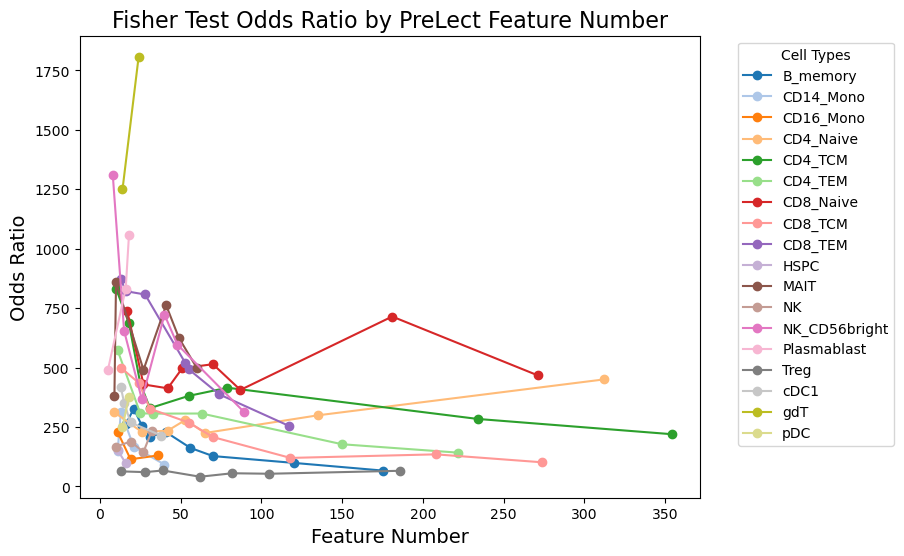

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\L2_fisher_result")
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/large_lambda_various/L2_fisher_result')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/large_lambda_various/L2_fisher_result')

color_count = 0
plt.figure(figsize=(8, 6))
for i, celltype in enumerate(types):
    if celltype in ['CD4_CTL', 'CD4_Proliferating']:
        # Odds ratio = INF when feature number are few
        print('Skipping', celltype)
        continue
    try:
        fisher_result = pd.read_csv(f'{celltype}_fisher_result.csv', index_col=0)
        if fisher_result.empty:
            print('Result empty', celltype)
            continue
        elif len(fisher_result) == 1:
            print('Result single lambda', celltype)
            continue
    except:
        print('No file', celltype)
        continue
    
    # plt.plot(fisher_result['Feature_no'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=l2_colors[i])
    plt.plot(fisher_result['Feature_no'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=tab20[color_count])
    color_count += 1

plt.xlabel('Feature Number', fontsize=14)
plt.ylabel('Odds Ratio', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
plt.title('Fisher Test Odds Ratio by PreLect Feature Number', fontsize=16)
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

No file ASDC
No file B_intermediate
Result single lambda B_naive
Skipping CD4_CTL
Skipping CD4_Proliferating
No file CD8_Proliferating
No file Doublet
Result empty Eryth
No file ILC
No file NK_Proliferating
Result empty Platelet
Result single lambda cDC2
No file dnT


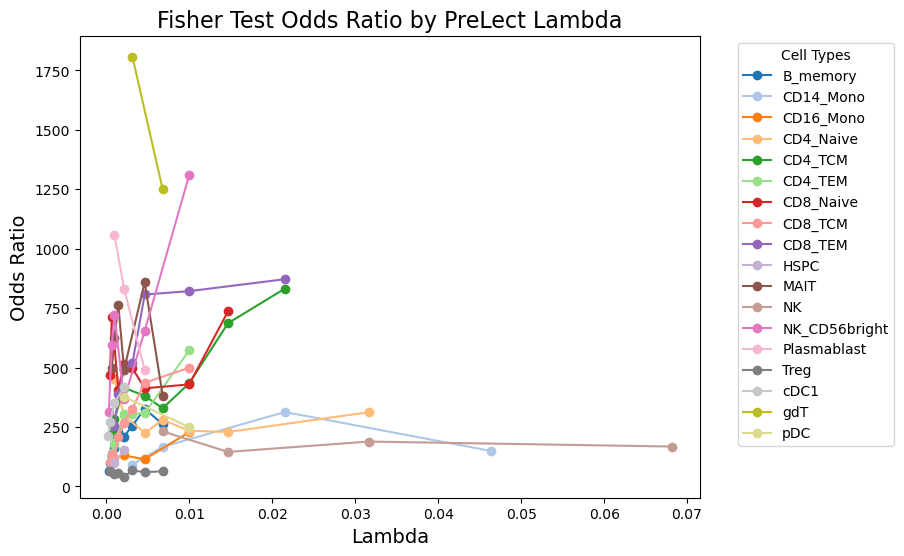

In [17]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\large_lambda_various\L2_fisher_result")

color_count = 0
plt.figure(figsize=(8, 6))
for i, celltype in enumerate(types):
    if celltype in ['CD4_CTL', 'CD4_Proliferating']:
        print('Skipping', celltype)
        continue
    try:
        fisher_result = pd.read_csv(f'{celltype}_fisher_result.csv', index_col=0)
        if fisher_result.empty:
            print('Result empty', celltype)
            continue
        elif len(fisher_result) == 1:
            print('Result single lambda', celltype)
            continue
    except:
        print('No file', celltype)
        continue
    
    # plt.plot(fisher_result['Lambda'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=l2_colors[i])
    plt.plot(fisher_result['Lambda'], fisher_result['Odds_ratio'], marker='o', label=celltype, color=tab20[color_count])
    color_count += 1

plt.xlabel('Lambda', fontsize=14)
plt.ylabel('Odds Ratio', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
plt.title('Fisher Test Odds Ratio by PreLect Lambda', fontsize=16)
plt.legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()